count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


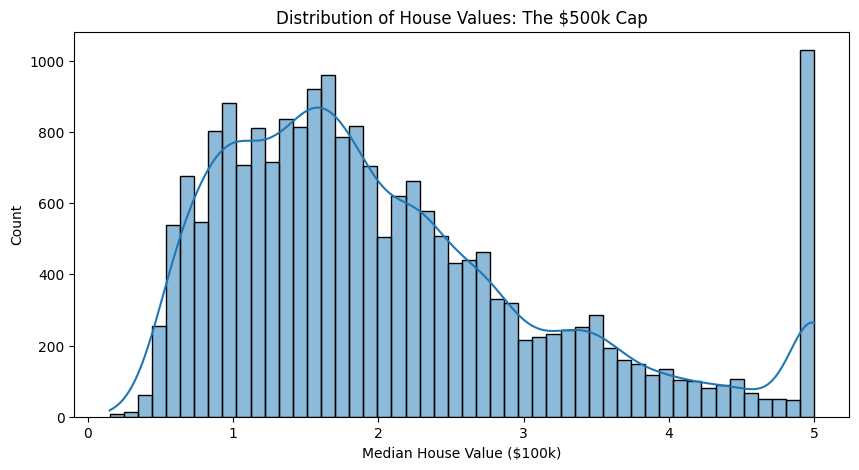

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# 2. Inspect the "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

In [2]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


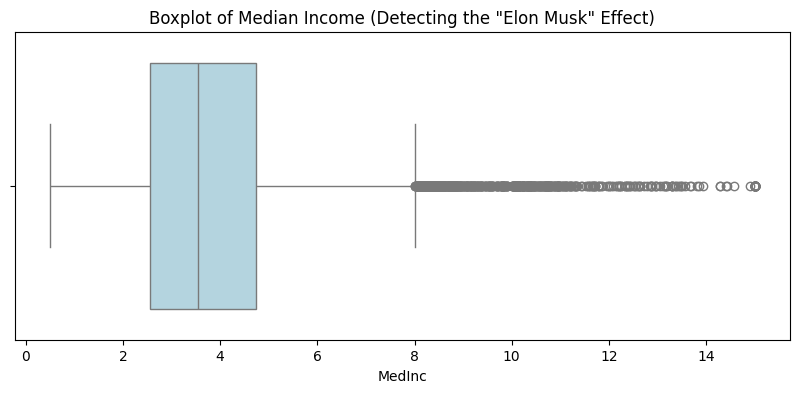

In [3]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [4]:
# Initialize the model
# contamination=0.05: We estimate ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Features to analyze (Income, House Age, Average Rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


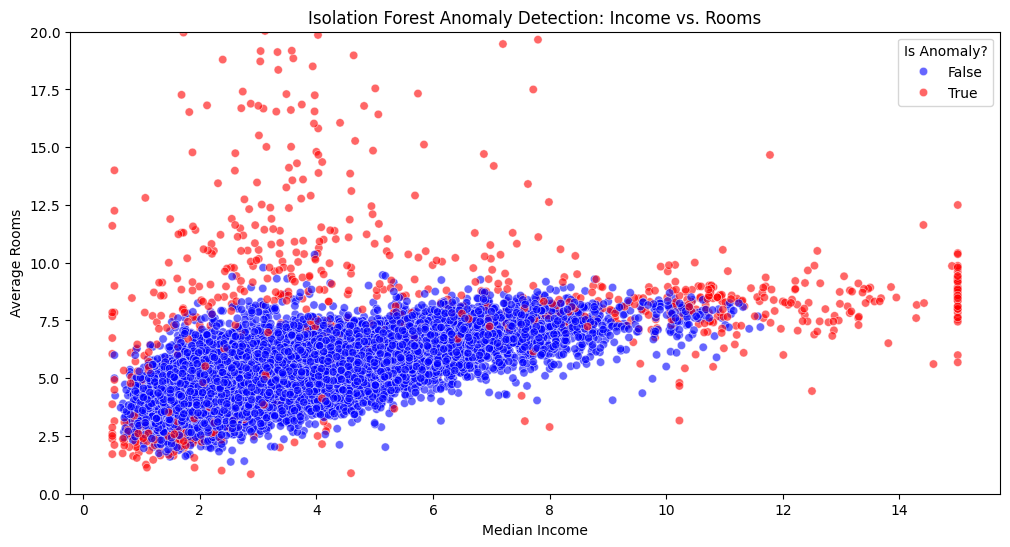

In [5]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df, 
    x='MedInc', 
    y='AveRooms', 
    hue='outlier_iso', 
    palette={True: 'red', False: 'blue'}, 
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()


=== Mean vs Median Summary ===
     Group  MedInc_Mean  MedInc_Median  MedHouseVal_Mean  MedHouseVal_Median
0   Normal     3.769613        3.51560          2.037000               1.789
1  Outlier     5.790782        4.25695          2.668172               2.057

=== Volatility Comparison (Std vs MAD) ===
     Group  MedInc_Std  MedInc_MAD  MedHouseVal_Std  MedHouseVal_MAD
0   Normal    1.640561     1.03165         1.114117            0.674
1  Outlier    4.145354     2.49190         1.634770            1.103

=== Inequality Wedge (Outliers Only) ===
      Variable  Inequality_Wedge (Mean - Median)
0       MedInc                          1.533832
1  MedHouseVal                          0.611172


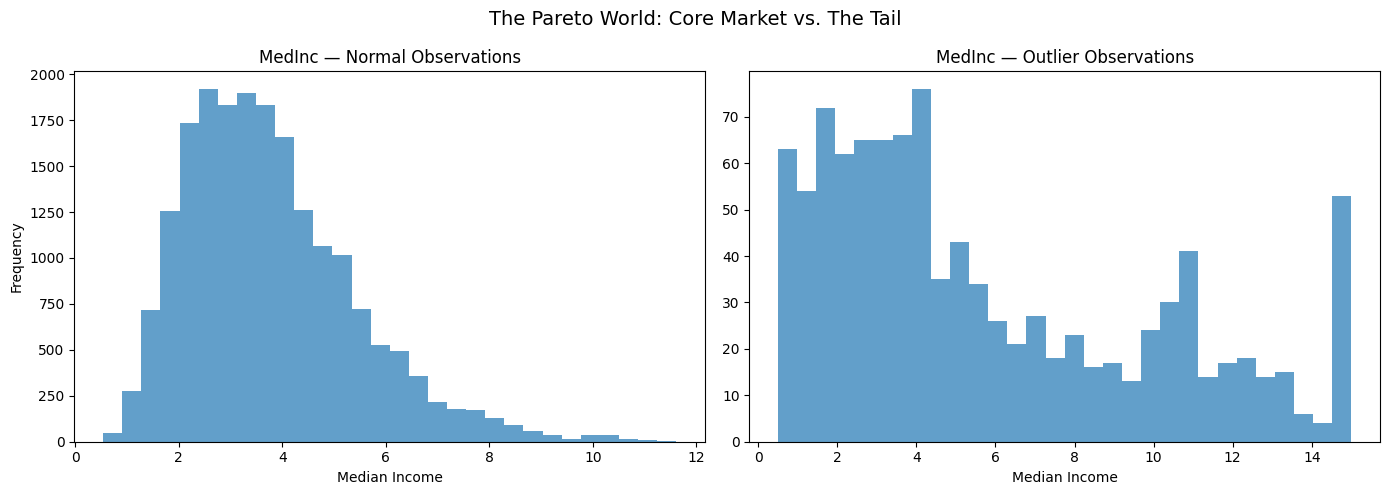

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Split the data
# -----------------------------
df_normal = df[df['outlier_iso'] == False]
df_outlier = df[df['outlier_iso'] == True]

# -----------------------------
# 2. Mean & Median calculations
# -----------------------------
summary_stats = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    
    'MedInc_Mean': [
        df_normal['MedInc'].mean(),
        df_outlier['MedInc'].mean()
    ],
    'MedInc_Median': [
        df_normal['MedInc'].median(),
        df_outlier['MedInc'].median()
    ],
    
    'MedHouseVal_Mean': [
        df_normal['MedHouseVal'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'MedHouseVal_Median': [
        df_normal['MedHouseVal'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

# -----------------------------
# 3. Volatility: Std Dev vs MAD
# -----------------------------
def mad(series):
    return np.median(np.abs(series - np.median(series)))

volatility = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    
    'MedInc_Std': [
        df_normal['MedInc'].std(),
        df_outlier['MedInc'].std()
    ],
    'MedInc_MAD': [
        mad(df_normal['MedInc']),
        mad(df_outlier['MedInc'])
    ],
    
    'MedHouseVal_Std': [
        df_normal['MedHouseVal'].std(),
        df_outlier['MedHouseVal'].std()
    ],
    'MedHouseVal_MAD': [
        mad(df_normal['MedHouseVal']),
        mad(df_outlier['MedHouseVal'])
    ]
})

# -----------------------------
# 4. Inequality Wedge (Outliers)
# -----------------------------
inequality_wedge = pd.DataFrame({
    'Variable': ['MedInc', 'MedHouseVal'],
    'Inequality_Wedge (Mean - Median)': [
        df_outlier['MedInc'].mean() - df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].mean() - df_outlier['MedHouseVal'].median()
    ]
})

# Print tables
print("\n=== Mean vs Median Summary ===")
print(summary_stats)

print("\n=== Volatility Comparison (Std vs MAD) ===")
print(volatility)

print("\n=== Inequality Wedge (Outliers Only) ===")
print(inequality_wedge)

# -----------------------------
# Visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Normal MedInc
axes[0].hist(df_normal['MedInc'], bins=30, alpha=0.7)
axes[0].set_title('MedInc — Normal Observations')
axes[0].set_xlabel('Median Income')
axes[0].set_ylabel('Frequency')

# Right: Outlier MedInc
axes[1].hist(df_outlier['MedInc'], bins=30, alpha=0.7)
axes[1].set_title('MedInc — Outlier Observations')
axes[1].set_xlabel('Median Income')

fig.suptitle('The Pareto World: Core Market vs. The Tail', fontsize=14)
plt.tight_layout()
plt.show()
